In [1]:
%matplotlib inline

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

import os
import time
import csv
import shelve
from datetime import datetime

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib import cm

import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d
print theano.config.device # We're using CPUs (for now)
print theano.config.floatX # Should be 64 bit for CPUs

np.random.seed(0)

###Data import, scaling and randomization

In [2]:
FTRAIN = './Data/FKD_Train.csv'
FTEST = './Data/FKD_Test.csv'

def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

#     print(df.count())  # prints the number of values for each column
#     df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        # scale target coordinates to [-1, 1] - need because we don't have bias on the net
        y = (y - 48) / 48  # 96/2=48
#         X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
    else:
        y = None

    return X, y, np.array(df.columns[:-1])

X, y, y_name = load()
X_t, trash, junk = load(test=True)
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))
print("X_t.shape == {}; X_t.min == {:.3f}; X_t.max == {:.3f}".format(X_t.shape, X_t.min(), X_t.max()))

X.shape == (7049L, 9216L); X.min == 0.000; X.max == 1.000
y.shape == (7049L, 30L); y.min == nan; y.max == nan
X_t.shape == (1783L, 9216L); X_t.min == 0.000; X_t.max == 1.000


###Baseline - Mean Patch Searching algorithm
 - http://cs229.stanford.edu/proj2014/Yue%20Wang,Yang%20Song,Facial%20Keypoints%20Detection.pdf

In [ ]:
class MeanPatchSearching:
    # Initialize an instance of the class.
    def __init__(self, patch_size=10, search_size=10, stretch=True):
        self.patch_size = patch_size
        self.search_size = search_size
        self.isStretch = stretch
        self.patch_index = np.array([[i,j] for i in range(-patch_size, patch_size+1) 
                                           for j in range(-patch_size, patch_size+1)])
        self.search_index = np.array([[i,j] for i in range(-search_size, search_size+1) 
                                            for j in range(-search_size, search_size+1)])
    
    # train the model
    def fit(self, train_faces, train_coordinates):
        start = datetime.now()
        # stretch input if needed
        if False: #self.isStretch:
            train_faces = np.array([self._histogramStretching(x) for x in train_faces])
        # number of faces to train
        self.num_examples = train_faces.shape[0]
        print 'number of training faces: %d' %self.num_examples
        # assuming coordinates are (x,y) pairs for each key point
        self.num_keypoints = train_coordinates.shape[1]/2
        # image dimension
        self.ncolumn = np.sqrt(train_faces.shape[1])
        self.nrow = self.ncolumn
        
        # get patches and their centers for all keypoints
        self.patches, self.patch_centers = [], []
        for i in range(self.num_keypoints):
            # get coordinates of current keypoint
            coordinates = train_coordinates[:,i*2:(i+1)*2]
            # filter zero values (empty from file)
            picker = coordinates[:,0]>0                        
            # get patch if at least one face has this point
            if sum(picker)>0:
                # get patch for this key point
                self.patches.append(self._getPatch(train_faces[picker], coordinates[picker]))
                # get center for this keypoint
                self.patch_centers.append(np.mean(coordinates[picker], axis=0))
        
        # convert to numpy array      
        self.patches = np.array(self.patches)
        self.patch_centers = np.array(self.patch_centers)
        self.num_keypoints = self.patches.shape[0]
        self.training_time = (datetime.now()-start).total_seconds()/60.0
        print 'training patches shape: %s' %str(self.patches.shape)
        print 'training time: %.1f minutes' %self.training_time
        # show training patches
#         self._plotPatches()
        
    # Make prediction for each test face and return coordinates.
    def predict(self, test_faces):
        start = datetime.now()
        # stretch input if needed
        if self.isStretch:
            test_faces = np.array([self._histogramStretching(x) for x in test_faces])
        self.num_predict = test_faces.shape[0]
        print 'number of predicting faces: %d' %self.num_predict
        predictions = []
        for i in range(self.num_predict):
            if np.mod((i+1), self.num_predict/10)==0:
                print 'Complete %d%% ...' %(100.0*(i+1)/self.num_predict)
            pred = self._predictOneFace(test_faces[i])            
            predictions.append(np.reshape(pred, (1,2*self.num_keypoints))[0])        
        self.pred_coor = np.array(predictions)
        self.predict_time = (datetime.now()-start).total_seconds()/60.0
        print 'Done! - Predict time: %.1f minutes' %self.predict_time
        return self.pred_coor
    
    # calculate total Root Mean Squared Error (RMSE)
    def RMSE(self, actual, pred=[]):
        if len(pred)==0:
            pred = self.pred_coor
        picker = actual>0        
        tRMSE = np.sqrt(np.sum((actual[picker]-pred[picker])**2)/np.sum(picker)) 
        return 'Total RMSE: %.2f, patch size: %d, search size: %d' %(tRMSE, self.patch_size, self.search_size)
    
    # save the submission file based on prediction made for test images
    def getSubmission(self, LookupTable, feature_name):
        # create a dictionary for feature name indexing
        feature_index = {x:np.where(feature_name==x)[0][0] for x in feature_name}
        lookupRow = []
        with open(LookupTable) as csvfile:
            # read the lookup file
            lookupReader = csv.reader(csvfile, delimiter=',')
            lookupRow.append(lookupReader.next())
            for row in lookupReader:
                # get the prediction based on image ID and feature name, and attach to the row
                location = self.pred_coor[int(row[1])-1, feature_index[row[2]]]
                lookupRow.append(np.append(row, location))
        lookupRow = np.array(lookupRow)
        # save row ID and location ID columns only to the submission file
        saveFile = 'submission_'+datetime.now().strftime("%Y%m%d%H%M%S")+'.csv'
        with open(saveFile, 'wb') as f:
            writer = csv.writer(f)
            writer.writerows(lookupRow[:,[0,3]])
        print 'Submission file saved as: %s' %saveFile
        return lookupRow
        
    # get the prediction for one face
    def _predictOneFace(self, face):
        # get prediction for each keypoint available in the model
        pred_coor = []
        for gold_p, center in zip(self.patches, self.patch_centers):
            # get the candidate points based on search size
            candidates = self._getCandidates(center)
            # get a patch for each candidate point     
            pred_p = [self._getPatch([face], [x]) for x in candidates]

            # compare the patches from candidate points with gold_p
            # TODO: use better distance
            dist = [np.sum(np.abs(gold_p-x)) for x in pred_p]
            pred_coor.append(candidates[np.argmin(dist)])
        return pred_coor
    
    # get the candidate points - return the coordinates
    def _getCandidates(self, center):  
        r, c = np.round(center)
        candidates = np.array([[r+i, c+j] for i,j in self.search_index])
        # only keep those within the bound
        picker = (np.sum(candidates>=0,axis=1) + np.sum(candidates<[self.nrow,self.ncolumn],axis=1))==4        
        return candidates[picker]
    
    # get the patch for one keypoint from all faces
    def _getPatch(self, faces, keypoints):    
        patches = []
        for face, keypoint in zip(faces, keypoints):
            # get keypoint pixel row and column index
            r, c = np.round(keypoint)        
            # get indices for the patch (including self)
            neighbors = np.array([[r+i, c+j] for i,j in self.patch_index])
            if np.sum(neighbors>=0)+np.sum(neighbors<[self.nrow,self.ncolumn]) == np.prod(neighbors.shape)*2:
                patches.append(face[[r*self.ncolumn + c for r,c in neighbors]])
#             else:
#                 print 'warning - nonconforming patch'
#         print np.array(patches).shape
        return np.mean(patches, axis=0)

    # histogram stretching pre-processing
    def _histogramStretching(self, image):
        # a, b = min(image), max(image) 
        a, b = np.percentile(image, 5), np.percentile(image, 95)
        l, u = 0, 255
        const = 1.0*(b*l - a*u)/(b - a)
        k = 1.0*(u-l)/(b-a)
        return [k*p+const for p in image]
    
    # plot average patch from training
    def _plotPatches(self):
        n_side = 2*self.patch_size+1
        keypoints = np.reshape([x[:-2] for x in feature_name],(self.num_keypoints,2))
        plt.figure(figsize=(16, 8))
        i = 1
        for point, patch in zip(keypoints[:,0], self.patches):
            plt.subplot(3,5,i)
            plt.imshow(np.reshape(patch,(n_side,n_side)), cmap = cm.gray)
            plt.title(point)
            plt.axis('off')
            i += 1
        plt.show()
        

##### Get baseline score
# training
mps = MeanPatchSearching(patch_size=9, search_size=5, stretch=True)
mps.fit(train_faces[:150], train_coordinates[:150])
# predicting
predictions = mps.predict(test_faces)
mps.getSubmission('./Data/FKD_IdLookupTable.csv', feature_name)

###Feature engineering 1: Histogram Stretching
 - $a$ and $b$ are 5 and 95 percentile of the image
 - $l$ and $u$ are 0 and 1 respectively for the maximum range
 - histogram stretching transfers any point $p$ of the image to $p^{\prime}$ such that: $\displaystyle \frac{p-a}{b-a} = \frac{p^{\prime}-l}{u-l} $
 - the transferred image is expected to have better contrast

In [3]:
def HistogramStretching(image):
#     a, b = min(image), max(image) 
    a, b = np.percentile(image, 5), np.percentile(image, 95)
    l, u = 0, 1
    const = 1.0*(b*l - a*u)/(b - a)
    k = 1.0*(u-l)/(b-a)
    return [k*p+const for p in image]

X = [HistogramStretching(x) for x in X]
X_t = [HistogramStretching(x) for x in X_t]
print 'Histogram stretching completed!'

Histogram stretching completed!


###Feature engineering 2: Gaussian Blur
 - reference: http://www.pixelstech.net/article/1353768112-Gaussian-Blur-Algorithm

In [5]:
# define the Gaussian weights of neighbors as constant variable
sigma2 = 1.25**2
neighborIndex = [[i,j] for i in range(-1,2) for j in range(-1,2)]
gaussianWeight = np.array([np.exp(-(i**2+j**2)/(2*sigma2))/(2*np.pi*sigma2) for i,j in neighborIndex])
gaussianWeight = gaussianWeight / sum(gaussianWeight)

# function to return the index of neighborhood pixels for pixel at n
def getNeighborAndWeight(n, ncolumn, nrow):    
    # get row and column id first for index i
    (r, c) = divmod(n, ncolumn)
    # get indices for the neighbors (including self)
    neighbors = [[r+i,c+j] for i,j in neighborIndex]
    # get neighbor index and the associated Gauusian weigth
    neighborWeights = []
    for nb, gw in zip(neighbors, gaussianWeight):  # range(len(neighbors)):
        r,c = nb
        if r>=0 and r<nrow and c>=0 and c<ncolumn:                  
            neighborWeights.append([r*ncolumn + c, gw])
    return neighborWeights

# apply Gaussian blur to one image
def gaussianBlurOneSample(x):
    y = np.empty(len(x))
    for i in range(len(x)):
        neighbors = getNeighborAndWeight(i,96,96)
        y[i] = sum([x[j[0]]*j[1] for j in neighbors])
    return y

start_time = time.time()
X = [gaussianBlurOneSample(x) for x in X]
X_t = [gaussianBlurOneSample(x) for x in X_t]
print 'Gaussian blur completed in %.f seconds!' %(time.time()-start_time)

Gaussian blur completed in 1085 seconds!


###Feature engineering 3: Flip image to increase training sample
 - flip the face horizontally
 - rename x features by switching left and right

In [6]:
# flip the image
X_flip = np.reshape(np.reshape(X, (-1,1,96,96))[:, :, :, ::-1], (-1, 96*96))

# flip the x coordinate value
multiplier = [-1,1]*(y.shape[1]/2)
y_flip = np.multiply([multiplier,]*y.shape[0], y)

# flip the x coordinates/column name
y_name_flip = []
for name in y_name:
    if 'left' in name.lower():
#         print name + ' --> ' + name.replace('left','right')
        y_name_flip.append(name.replace('left','right'))
    elif 'right' in name.lower():
#         print name + ' --> ' + name.replace('right','left')
        y_name_flip.append(name.replace('right','left'))
    else:
        y_name_flip.append(name)
y_name_flip=np.array(y_name_flip)
isort = [np.where(y_name_flip==x)[0][0] for x in y_name]

# combine data and align with original column
y = np.concatenate((y, y_flip[:, isort]), axis=0)
X = np.concatenate((X, X_flip), axis=0)
print 'After merge X:%s, y:%s' %(X.shape, y.shape)

After merge X:(14098L, 9216L), y:(14098L, 30L)


###Feature engineering 4: Group image to obtain training sets
 - group images with same training keypoints
 

In [7]:
X_group, y_group = {}, {}
i = 0
for x,f in zip(X,y):    
    picker = ~np.isnan(f)
    id = str.join(',', y_name[picker])
    if id not in X_group:
        X_group[id] = []
        y_group[id] = []
    X_group[id].append(x)
    y_group[id].append(f[picker])
    
feature_size = np.array([np.array(x[1]).shape for x in y_group.items()]) 
big_group = feature_size[:,0].argsort()
n_top = 7
print '\nimages # vs. features # for top %d groups:' %n_top
print feature_size[big_group][-n_top:]

X1 = np.reshape(X_group.items()[big_group[-1]][1], (-1, 1, 96, 96))
X2 = np.reshape(X_group.items()[big_group[-2]][1], (-1, 1, 96, 96))
y1 = np.array(y_group.items()[big_group[-1]][1])
y2 = np.array(y_group.items()[big_group[-2]][1])
feature1 = y_group.keys()[big_group[-1]].split(',')
feature2 = y_group.keys()[big_group[-2]].split(',')
x_t = np.reshape(X_t, (-1, 1, 96, 96))

print '1st training set: X1:%s - y1:%s, y1.min:%.3f, y1.max:%.3f' %(str(X1.shape), str(y1.shape), y1.min(), y1.max())
print '2nd training set: X2:%s - y2:%s, y2.min:%.3f, y2.max:%.3f' %(str(X2.shape), str(y2.shape), y2.min(), y2.max())
print 'testing set: x_t:%s' %str(x_t.shape)


images # vs. features # for top 7 groups:
[[  12   26]
 [  20    6]
 [  26   28]
 [  57   28]
 [  57   28]
 [4280   30]
 [9510    8]]
1st training set: X1:(9510L, 1L, 96L, 96L) - y1:(9510L, 8L), y1.min:-0.986, y1.max:0.988
2nd training set: X2:(4280L, 1L, 96L, 96L) - y2:(4280L, 30L), y2.min:-0.964, y2.max:0.996
testing set: x_t:(1783L, 1L, 96L, 96L)


###Model 1 - Convolutional Neural Network by Lasagne
 - 3 Convolutional layers with reception filter: (3x3), (2x2), (2x2) respectively
 - number of layers: 32, 64, 128
 - https://github.com/Lasagne/Lasagne/blob/master/lasagne/layers/conv.py
 - 3 downsampling layers with filter size (2x2) for each
 - https://github.com/Lasagne/Lasagne/blob/master/lasagne/layers/pool.py
 - choose rectify activation function for each convolutional layer
 - https://github.com/dnouri/nolearn/blob/master/nolearn/lasagne/base.py

In [ ]:

def getCNN(n_output):
    net = NeuralNet(
        layers=[
            ('input', layers.InputLayer),
            ('conv1', layers.Conv2DLayer),
            ('pool1', layers.MaxPool2DLayer),
            ('conv2', layers.Conv2DLayer),
            ('pool2', layers.MaxPool2DLayer),
            ('conv3', layers.Conv2DLayer),
            ('pool3', layers.MaxPool2DLayer),
            ('hidden4', layers.DenseLayer),
            ('hidden5', layers.DenseLayer),
            ('output', layers.DenseLayer),
            ],
        input_shape=(None, 1, 96, 96),
        # 3 convoluational layer
        conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
        conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
        conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
        # 2 fully connected hidden layer
        hidden4_num_units=500, hidden5_num_units=500,
        # fully connected output layer, no activation function to give continuous output
        output_num_units=n_output, output_nonlinearity=None,

        update_learning_rate=0.02,
        update_momentum=0.9,
    
        regression=True,
        max_epochs=50,
        verbose=1,
        )
    return net

  input             	(None, 1, 96, 96)   	produces    9216 outputs
  conv1             	(None, 32, 94, 94)  	produces  282752 outputs
  pool1             	(None, 32, 47, 47)  	produces   70688 outputs
  conv2             	(None, 64, 46, 46)  	produces  135424 outputs
  pool2             	(None, 64, 23, 23)  	produces   33856 outputs
  conv3             	(None, 128, 22, 22) 	produces   61952 outputs
  pool3             	(None, 128, 11, 11) 	produces   15488 outputs
  hidden4           	(None, 500)         	produces     500 outputs
  hidden5           	(None, 500)         	produces     500 outputs
  output            	(None, 8)           	produces       8 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -------
      1       0.01655       0.00784      2.11177  533.37s
      2       0.00807       0.00703      1.14848  547.11s
      3       0.00752       0.00662      1.13604  567.80s
      4       0.00720       0.00636      1.1

###Train, predict and assemble result to generate submission file
 - train one model (net1) with X1 dataset - 9510 images with 4 key points
 - train one model (net2) with X2 dataset - 4280 images with all 15 key points
 - each model predicts for 1783 testing images, and gives predictions for their training key ponits
 - for common points we take the mean between two predictions
 

In [8]:
##### CNN for X1 training set () ##### #0.00518 
net1 = getCNN(y1.shape[1])
net1.fit(X1, y1)
start_time = time.time()
y_hat1 = net1.predict(x_t)*48+48
print 'Prediction time: %.2f sec, y_hat1.%s' %(time.time()-start_time, str(y_hat1.shape))
save(['y_hat1'])

##### CNN for X2 training set () ##### #0.00456
net2 = getCNN(y2.shape[1])
net2.fit(X2, y2)
start_time = time.time()
y_hat2 = net2.predict(x_t)*48+48 # rescale it back
print 'Prediction time: %.2f sec, y_hat2.%s' %(time.time()-start_time, str(y_hat2.shape))

save(['y_hat1','y_hat2'])

##### get submission file - group 2 has all points
def getSubmission(LookupTable):
    # create a dictionary for feature name indexing
    index2 = {feature2[x]:x for x in range(len(feature2))}
    index1 = {feature1[x]:x for x in range(len(feature1))}
    lookupRow = []
    with open(LookupTable) as csvfile:
        # read the lookup file
        lookupReader = csv.reader(csvfile, delimiter=',')
        lookupRow.append(lookupReader.next())
        for row in lookupReader:
            # get the prediction based on image ID and feature name, and attach to the row
            image_id, fea = int(row[1])-1, row[2]
            location = y_hat2[image_id, index2[fea]]
            if fea in index1:
                location = (location + y_hat1[image_id, index1[fea]])/2
            lookupRow.append(np.append(row, location))
    lookupRow = np.array(lookupRow)
    # save row ID and location ID columns only to the submission file
    saveFile = 'submission_' + datetime.now().strftime("%Y%m%d%H%M%S") + '.csv'
    with open(saveFile, 'wb') as f:
        writer = csv.writer(f)
        writer.writerows(lookupRow[:,[0,3]])
    print 'Submission file saved as: %s' %saveFile

getSubmission('./Data/FKD_IdLookupTable.csv')

Prediction time: 51.67 sec, y_hat1.(1783, 8)
Submission file saved as: submission_20150726132410.csv


###Error Analysis
 1. Rank prediction error on keypoints and images
  - actual [num_test, num_coordinates] - actual keypoint coordinates from testing faces
  - prediction [num_test, num_coordinates] - predicted keypoint cooridnates for testing faces
  - note: two inputs must have same dimension, and the function is not comparing the absent key points (0) on the face
 2. Visualization

In [ ]:
##### print a rank for predidction RMSE #####
def RankPredictionRMSE(actual, prediction):
    print '\nError Analysis:'
    feaRMSE, keyRMSE = [], []
    # for each feature
    for i in range(len(feature_name)):               
        picker = actual[:,i]>0
        feaRMSE.append(np.sqrt(np.mean((actual[picker,i]-prediction[picker,i])**2)))
    feaRMSE = np.array(feaRMSE)
    feaRank = np.argsort(feaRMSE)
    
    # for each keypoint
    keypoints = [x[:-2] for x in feature_name]
    indexes = np.unique(keypoints, return_index=True)[1]
    keypoints = np.array([keypoints[i] for i in sorted(indexes)])
    for i in range(len(keypoints)):
        act = actual[:,i*2:(i+1)*2]
        pre = prediction[:,i*2:(i+1)*2]
        picker = act[:,0]>0
        keyRMSE.append(np.sqrt(np.mean((act[picker]-pre[picker])**2)))
    keyRMSE = np.array(keyRMSE)
    keyRank = np.argsort(keyRMSE)
    showKey = np.append(keypoints[keyRank][::-1], np.zeros(shape=(len(keypoints),1)))
    showRMSE = np.append(keyRMSE[keyRank][::-1], np.zeros(shape=(len(keypoints),1)))
    
    # for each testing image    
    imgRMSE = np.array([np.sqrt(np.mean((pre[act>0]-act[act>0])**2)) for pre, act in zip(prediction, actual)])
    imgRank = np.argsort(imgRMSE)
    
    # print the RMSE ranking results    
    template = "{0:35}{1:20}{2:35}{3:10}"
    print template.format("feature name", "RMSE", "keypoint", "RMSE") # header
    for f, r1, k, r2 in zip(feature_name[feaRank][::-1], feaRMSE[feaRank][::-1], showKey, showRMSE):
        print template.format(f, *['%.3f' %r1, '%s' %(k if k!='0.0' else ''), '%s' %('%.3f' %r2 if r2!=0 else '')])
    
    # plot top 10 badly predicted testing faces   
    n_top = np.min([10, actual.shape[0]])
    print '\nTop %d faces with highest RMSE:' %n_top
    plt.figure(figsize=(20, 10))
    i=1
    for iid in imgRank[::-1][:n_top]:
        plt.subplot(2,5,i)        
        plt.imshow(np.reshape(dev_faces[iid], (96,96)), cmap = cm.gray)
        picker = actual[iid]>0
        pre = np.reshape(prediction[iid, picker],(sum(picker)/2,2))
        kp = np.reshape(actual[iid, picker], (sum(picker)/2,2))
        for a,p in zip(kp, pre):
            plt.plot(a[0],a[1],'r.')
            plt.plot(p[0],p[1],'c.')
        plt.axis('off')
        plt.title('[%d] RMSE: %.3f' %(iid,imgRMSE[iid]))
        i+=1

##### Visualization #####
def plot(image, points, pred=[]):
    # print a picture to see
    plt.figure(figsize=(8, 8))
    if len(image)==96:
        plt.imshow(image, cmap = cm.gray)
    else:
        plt.imshow(np.reshape(image,(96,96)), cmap = cm.gray)
    plt.axis('off')
    if len(points)>0:
        for i in range(len(points)/2):
            plt.plot(points[2*i], points[2*i+1],'r.')
    if len(pred)>0:
        for i in range(len(pred)/2):
            plt.plot(pred[2*i],pred[2*i+1],'c.')

###Saving features and results

In [10]:
def save(variables):
    filename='./Data/save_' + datetime.now().strftime("%Y%m%d%H%M%S") + '.out'
    my_shelf = shelve.open(filename,'n') # 'n' for new
    for key in dir():
        try:
            if key in variables: #['y_hat1', 'y_hat2', 'X', 'y']:
                my_shelf[key] = globals()[key]
        except TypeError:
            #
            # __builtins__, my_shelf, and imported modules can not be shelved.
            #
            print('ERROR shelving: {0}'.format(key))
    my_shelf.close()
    print 'Saving complete!'

Saving complete!


In [5]:
filename='./save1.out.db'
my_shelf = shelve.open(filename)
vNames = ""
for key in my_shelf:
    globals()[key]=my_shelf[key]
    vNames += key + ", "
my_shelf.close()
print 'loaded ' + vNames
# print globals()

loaded y_hat1, y_hat2, 


###Model 2 - Convolutional Neural Network by Theano

In [4]:
## (1) Parameters
numHiddenNodes = 600 
patchWidth = 3
patchHeight = 3
featureMapsLayer1 = 32
featureMapsLayer2 = 64
featureMapsLayer3 = 128

# For convonets, we will work in 2d rather than 1d.  The facial images are 96x96 in 2d.
imageWidth = 96
# n_train = np.round(X1.shape[0]*0.9)
# train_X, train_y =  X1[:n_train], y1[:n_train]
# test_X, test_y = X1[-n_train:], y1[-n_train:] 

n_train = np.round(X2.shape[0]*0.9)
train_X, train_y =  X2[:n_train], y2[:n_train]
test_X, test_y = X2[n_train:], y2[n_train:] 

# Convolution layers.  
w_1 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer1, 1, patchWidth, patchHeight))*.01)))
w_2 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer2, featureMapsLayer1, patchWidth-1, patchHeight-1))*.01)))
w_3 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer3, featureMapsLayer2, patchWidth-1, patchHeight-1))*.01)))
# Fully connected NN. - 12x12 - dimension of L3 (11) plus bias (1)
w_4 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer3 * 12 * 12, numHiddenNodes))*.01)))
w_5 = theano.shared(np.asarray((np.random.randn(*(numHiddenNodes, train_y.shape[1]))*.01)))
params = [w_1, w_2, w_3, w_4, w_5]

## (2) Model
theano.config.floatX = 'float64'
X = T.tensor4() # conv2d works with tensor4 type
Y = T.matrix()

srng = RandomStreams()
def dropout(X, p=0.):
    if p > 0:
        X *= srng.binomial(X.shape, p=1 - p)
        X /= 1 - p
    return X

# Theano provides built-in support for add convolutional layers
def model(X, w_1, w_2, w_3, w_4, w_5, p_1, p_2):
    l1 = dropout(max_pool_2d(T.maximum(conv2d(X, w_1, border_mode='full'), 0.), (2, 2)), p_1)
    l2 = dropout(max_pool_2d(T.maximum(conv2d(l1, w_2), 0.), (2, 2)), p_1)
    # flatten to switch back to 1d layers - with "outdim = 2" (2d) output 
    l3 = dropout(T.flatten(max_pool_2d(T.maximum(conv2d(l2, w_3), 0.), (2, 2)), outdim=2), p_1) 
    l4 = dropout(T.maximum(T.dot(l3, w_4), 0.), p_2)
    return T.dot(l4, w_5) #T.nnet.softmax(T.dot(l4, w_5))

y_hat_train = model(X, w_1, w_2, w_3, w_4, w_5, 0.2, 0.5)
y_hat_predict = model(X, w_1, w_2, w_3, w_4, w_5, 0., 0.)

## (3) Cost
cost = T.sqrt(T.mean(T.sqr(Y - y_hat_train))) # T.mean(T.nnet.categorical_crossentropy(y_hat_train, Y))

## (4) Minimization.  
def backprop(cost, w, alpha=0.01, rho=0.8, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        
        # adding gradient scaling
        acc = theano.shared(w1.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * grad ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        grad = grad / gradient_scaling
        updates.append((acc, acc_new))
        
        updates.append((w1, w1 - grad * alpha))
    return updates

update = backprop(cost, params)
train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_hat_predict, allow_input_downcast=True)

miniBatchSize = 1
def gradientDescentStochastic(epochs):
    print 'Training started @%s, buckle up!' %datetime.now()
    print 'Training set: %s, dev set: %s' %(train_y.shape, test_y.shape)
    
    start_time = time.time()
    for i in range(epochs):
        for start, end in zip(range(0, len(train_X), miniBatchSize), range(miniBatchSize, len(train_X), miniBatchSize)):
            cost = train(train_X[start:end], train_y[start:end])
#             print 'cost: %.3f' %cost
        print '%d) %s: RMSE = %.4f' %(i+1, datetime.now(), np.sqrt(np.mean(np.square(test_y - predict(test_X)))))
    print 'Total training time = %.2f' %(time.time() - start_time)

# gradientDescentStochastic(10)

# start_time = time.time()
# predict(test_data)   
# print 'predict time = %.2f' %(time.time() - start_time)

In [ ]:

gradientDescentStochastic(10)


Training started @2015-08-01 22:48:23.601778, buckle up!
Training set: (1926, 30), dev set: (214, 30)
1) 2015-08-01 23:07:12.475591: RMSE = 0.3904

###Visualization

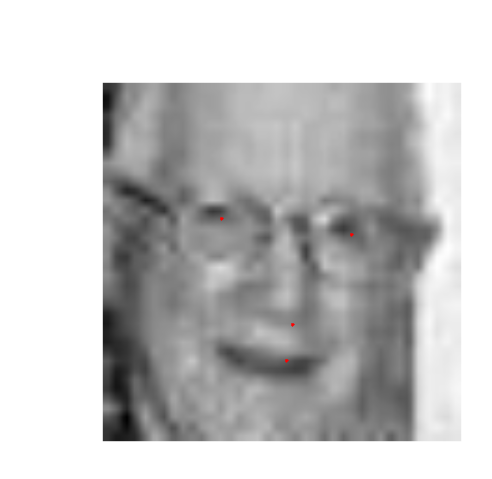

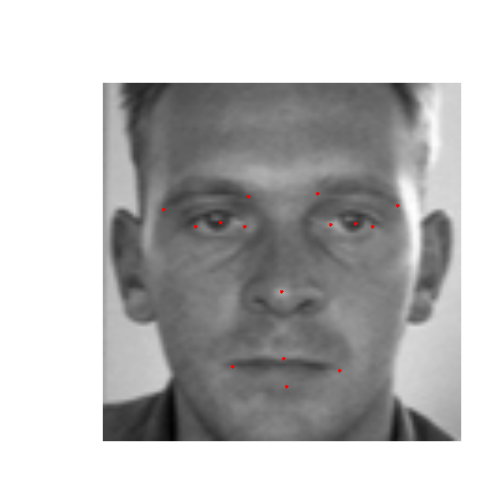

In [4]:


# testing example    
# ranges = [np.ptp(x) for x in X2]
# id = np.argsort(ranges)[0]
# plot(X2[0], 48*y2[0]+48)
# plot(X2[id], 48*y2[id]+48)
id=13
plot(X[id], 48*y[id]+48)
plot(X[id+X.shape[0]/2], 48*y[id+X.shape[0]/2]+48)